# Classification benchmark: PLN-Tree

In [1]:
from plntree.models import PLNTreeConditional, PLNTree
from plntree.utils.classifiers import DenseClassifier, RNNClassifier
from plntree.utils.jupyter_functions import *
from plntree.data.utils import numpy_dataset_to_torch_dataloader
import torch
import torch.optim as optim

2024-06-06 17:26:08.333467: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 17:26:08.335016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 17:26:08.356164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 17:26:08.356188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 17:26:08.356958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Metagenomics dataset

## Dataset import

In [2]:
seed = 0
# Select the taxonomic precision
precision = 'f'
prefix = f'metagenomics_classification_taxaL{precision}_s{seed}'

seed_all(seed)

In [3]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [4]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [5]:
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

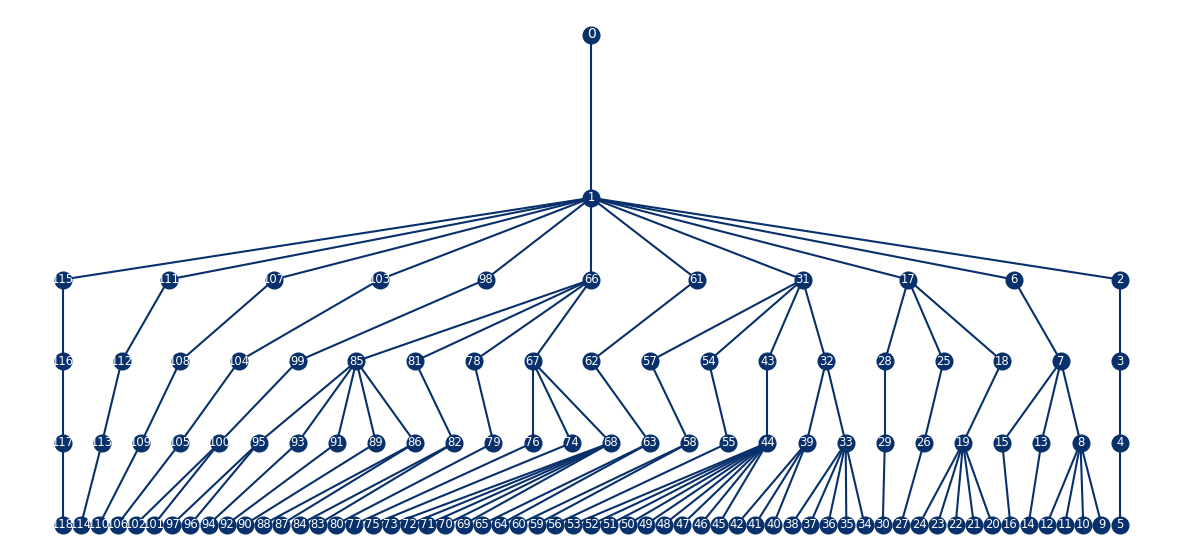

In [6]:
abundances = metagenomics_loader.raw_abundance_filter(raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')

In [7]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

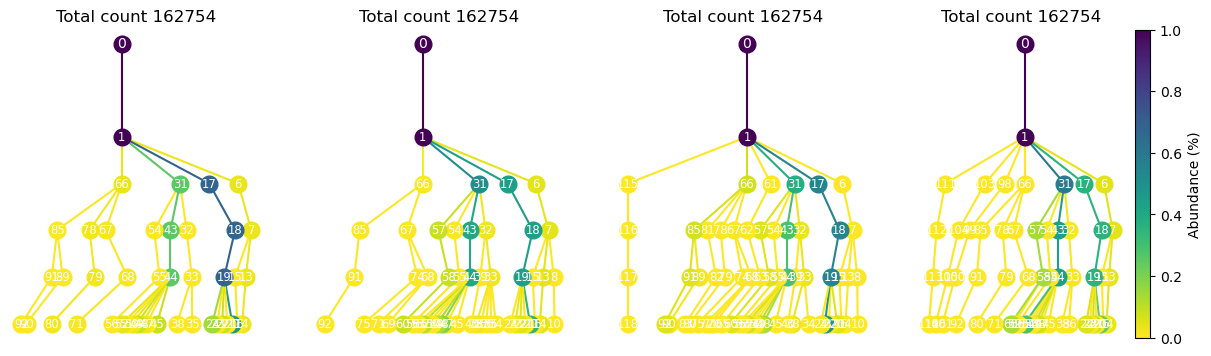

In [8]:
vizualize_samples(dataloader, taxonomy, selected_layers, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Visualize the problem's difficulty with PCA

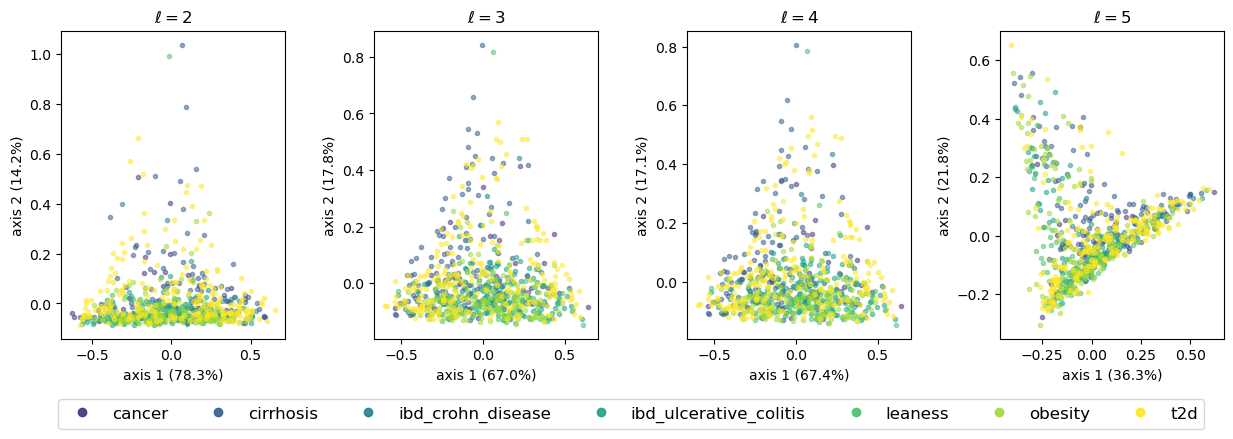

In [9]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease']
def plot_pca(Y_base, X_base):
    fig, axs = plt.subplots(1, len(K), figsize=(15, 4))
    colors = [matplotlib.cm.get_cmap('viridis')((i+1)/len(np.unique(Y_base))) for i, name in enumerate(np.unique(Y_base))]
    for layer, K_l in enumerate(K):
        X_l = X_base[:, layer, :K_l]
        pca = PCA(n_components=2, random_state=seed).fit(X_l)
        X_l_pca = pca.transform(X_l)
        for k, c in enumerate(np.unique(Y_base)):
            indexes = np.where(Y_base == c)
            axs[layer].set_title(f'$\ell = {layer + selected_layers[0]}$')
            axs[layer].plot(X_l_pca[indexes, 0], X_l_pca[indexes, 1], marker='.', linestyle='', color=colors[k], alpha=0.5)
            axs[layer].set_xlabel(f'axis 1 ({np.round(pca.explained_variance_ratio_[0] * 100, 1)}%)')
            axs[layer].set_ylabel(f'axis 2 ({np.round(pca.explained_variance_ratio_[1] * 100, 1)}%)')
    legend_handles = [
            mlines.Line2D([], [], marker='o', linestyle='', color=color, alpha=0.9, label=group)
            for color, group in zip(colors, np.unique(Y_base))
        ]
    legend = plt.legend(handles=legend_handles, fontsize="12", loc='lower center', bbox_to_anchor=(-1.65, -0.32), ncols=len(colors))
    plt.subplots_adjust(wspace=0.4)
plot_pca(Y_base, X_base / X_base[:, 0].sum(dim=-1, keepdims=True).unsqueeze(-1))
savefig(f'{prefix}_PCA_all_diseases')

In [10]:
n_classes = len(np.unique(Y_base))
n_classes

7

In [11]:
print(np.unique(Y_base, return_counts=True))

(array(['cancer', 'cirrhosis', 'ibd_crohn_disease',
       'ibd_ulcerative_colitis', 'leaness', 'obesity', 't2d'],
      dtype=object), array([ 48, 118,  25, 148,  89, 164, 223]))


## Preprocessing using PLN models

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 905 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 912 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 903 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 867 iterations
Likelihood: -45823.946182489395


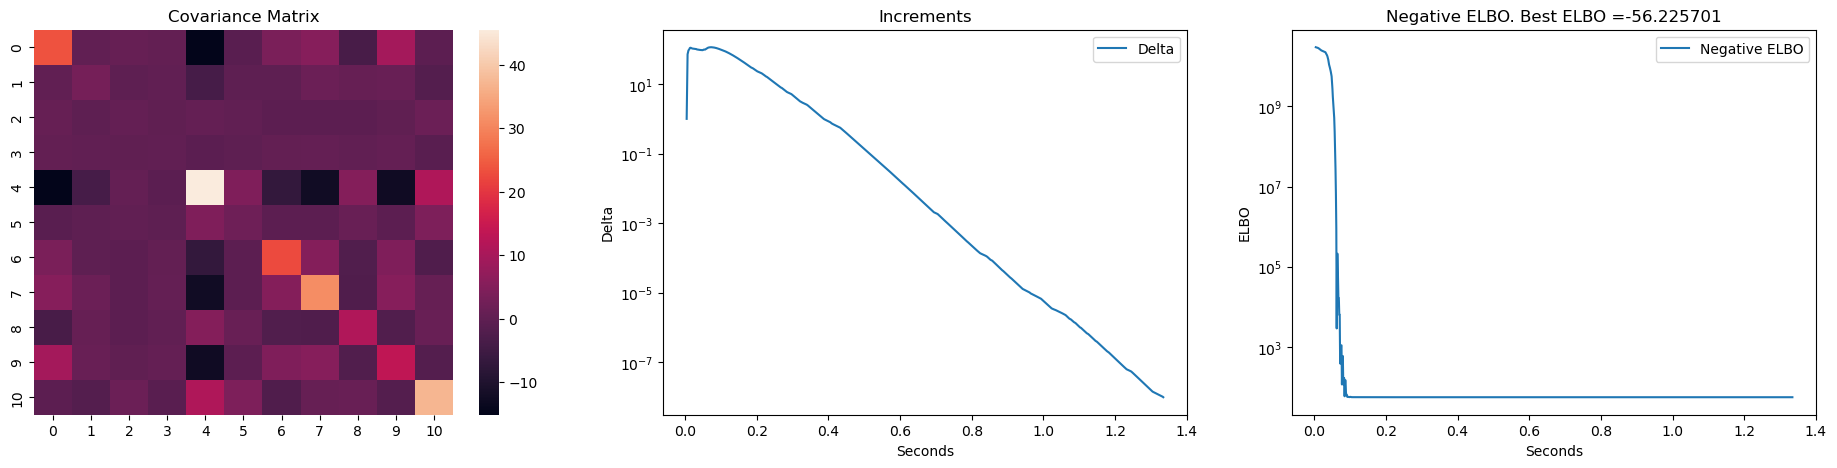

Likelihood: -81056.4235496521


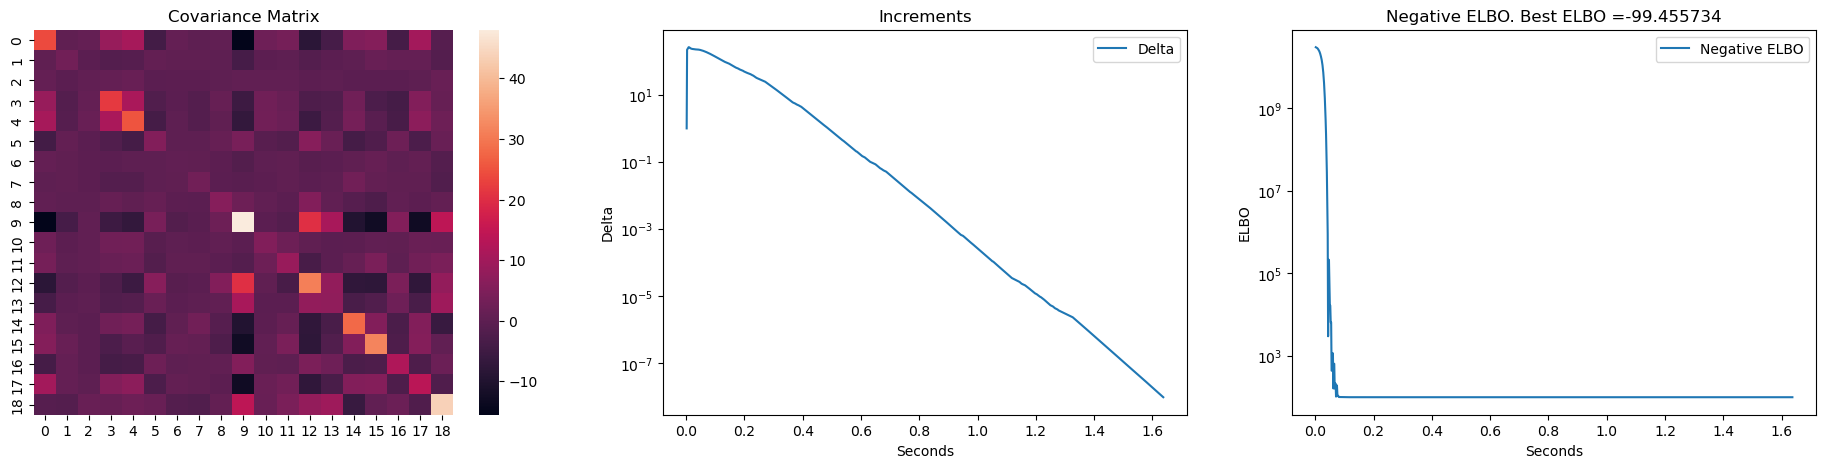

Likelihood: -96048.11929988861


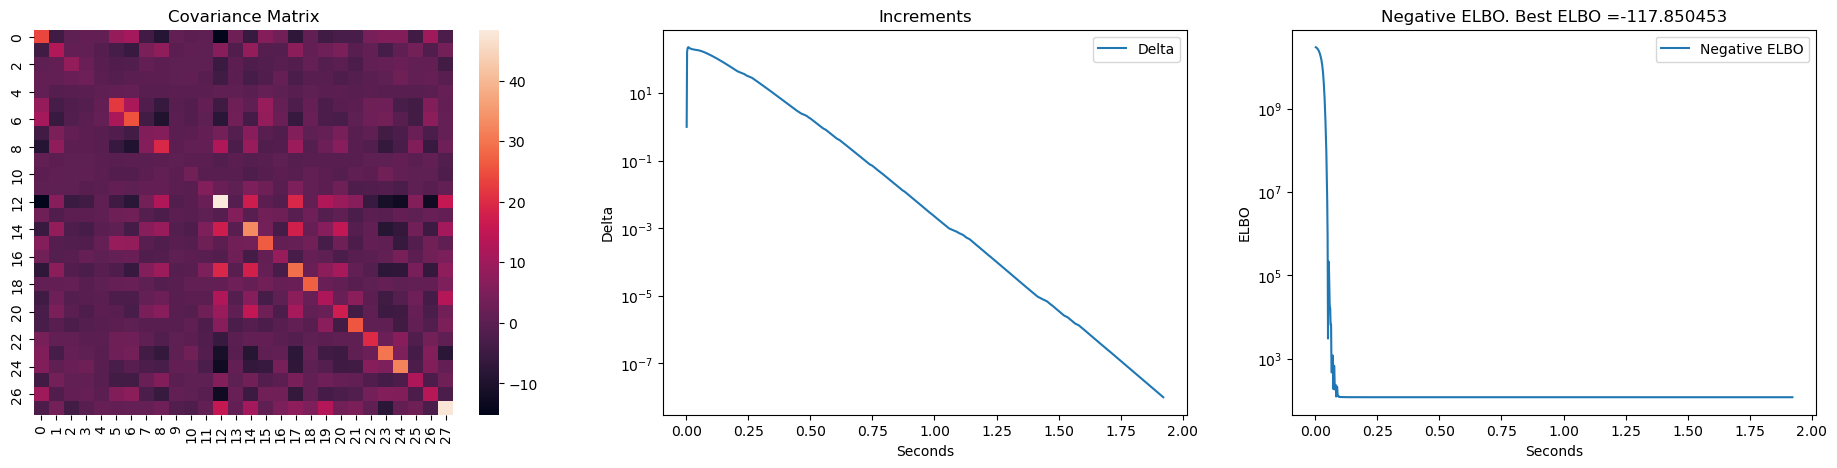

Likelihood: -182364.0980257988


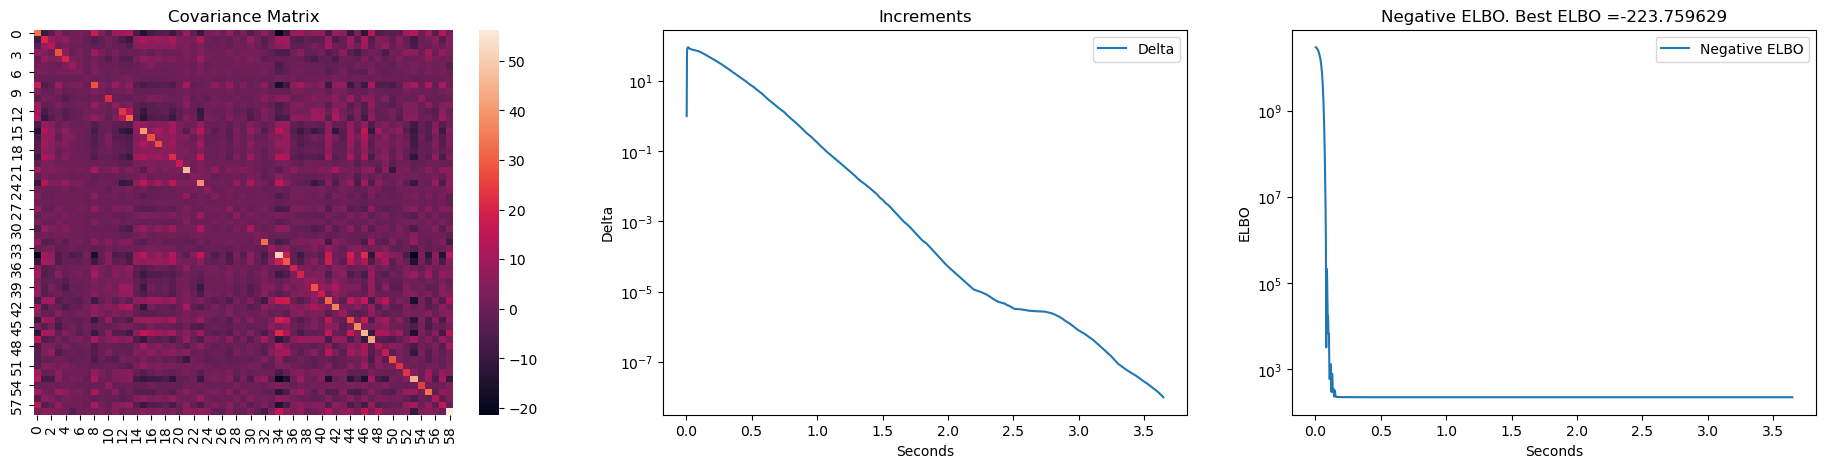

In [12]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [13]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

n_latent_layers = 1
n_variational_layers = 3
preprocessing = 'proportion'
print('Latents size', n_latent_layers)
print('Variational size', n_variational_layers)
variational_approx_params = {
    'n_variational_layers':n_variational_layers,
    'preprocessing': [preprocessing]
}
params, suffix = get_plntree_params_and_suffix(n_latent_layers, 'mean_field', variational_approx_params)
try:
    meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
except:
    meanfield, meanfield_losses = learn_plntree_mean_field(params)
    save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')

Latents size 1
Variational size 3
Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_mean_field_proportion_latentlayers-1_varlayers-3.pkl


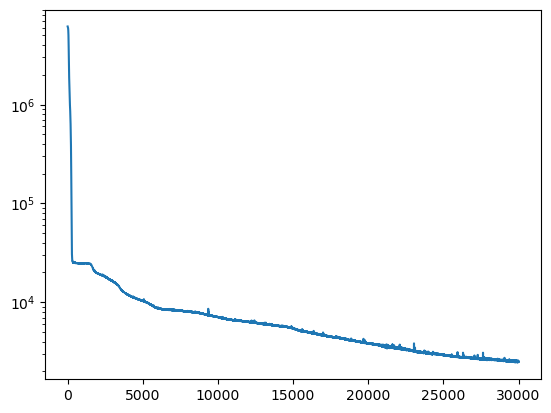

In [14]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses)
axs.set_yscale('log')

In [15]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

n_latent_layers = 1
emb_name, variational_approx_params = embedder_params(
    embedding_size=32,
    n_embedding_layers=2,
    n_embedding_neurons=64,
    n_after_layers=2
)
try:
    backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
except:
    print('Learning PLN-Tree (residual backward)')
    print(variational_approx_params)
    backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
    save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')

Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl


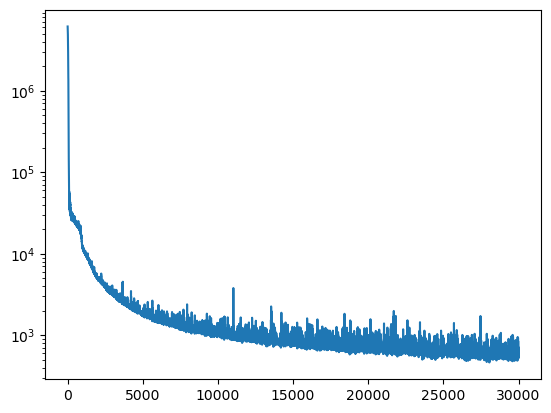

In [16]:
fig, axs = plt.subplots()
axs.plot(backward_losses)
axs.set_yscale('log')

In [17]:
Z_meanfield, _ = meanfield.encode(X_base, seed=seed)
Z_backward, _ = backward.encode(X_base, seed=seed)

In [18]:
Z_pln_enc = generate_pln_data(pln_layers, 1, K, selected_layers, X_base, taxonomy, seed=seed)[-2]

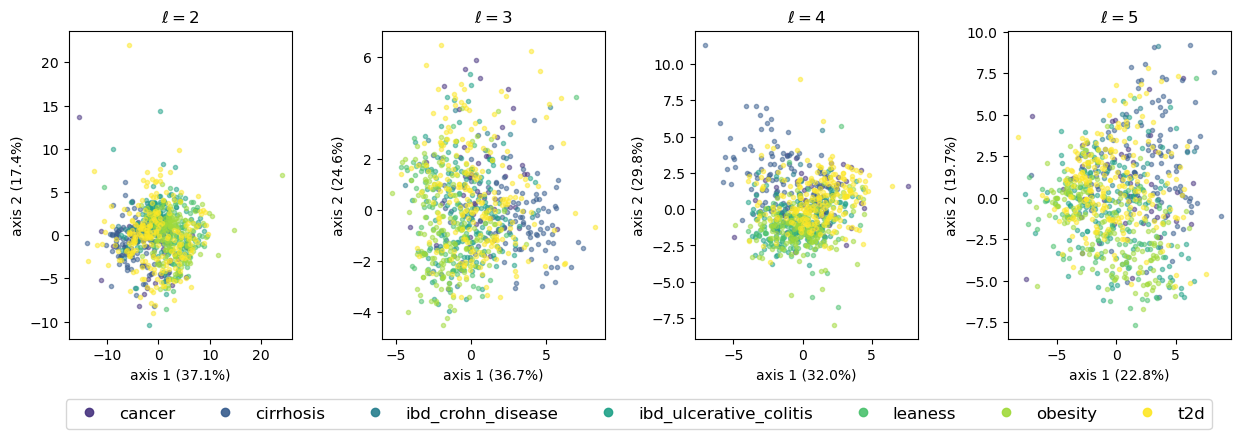

In [19]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, Z_backward.detach())

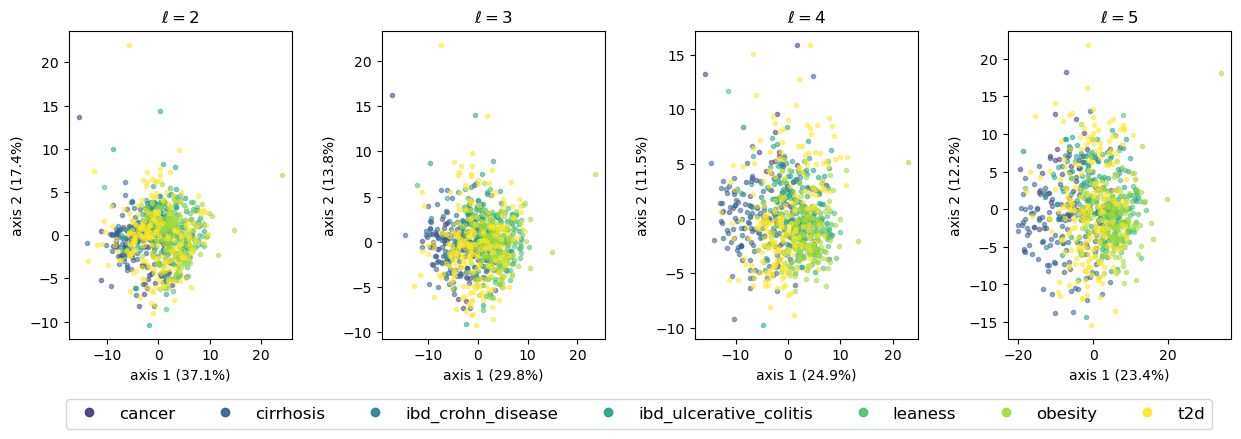

In [20]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, torch.log(backward.latent_tree_allocation(Z_backward)).detach())
savefig(f'{prefix}_PCA_all_diseases_latent_allocation')

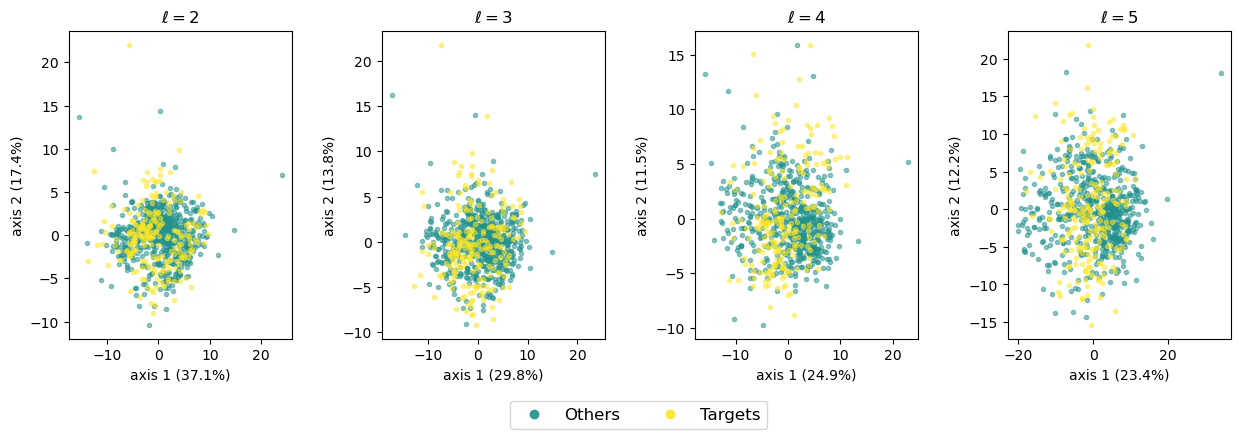

In [84]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

scenario = 't2d'

if scenario == 'ibd':
    filtered_labels = ['ibd_crohn_disease', 'ibd_ulcerative_colitis']
elif scenario == 'cirrhosis':
    filtered_labels = ['cirrhosis']
elif scenario == 'obesity':
    filtered_labels = ['obesity']
elif scenario == 'colorectal':
    filtered_labels = ['cancer']
elif scenario == 't2d':
    filtered_labels = ['t2d']
elif scenario == 't2d_obe':
    filtered_labels = ['t2d', 'obesity']
elif scenario == 'cirr_col':
    filtered_labels = ['cirrhosis', 'colorectal']
prefix_labels = ''
for label in filtered_labels:
    prefix_labels += f'-{label}'
Y_base = metadata['disease'].copy()
for i in range(len(Y_base)):
    if Y_base[i] not in filtered_labels:
        Y_base[i] = 'Others'
    else:
        Y_base[i] = 'Targets'

plot_pca(Y_base, torch.log(backward.latent_tree_allocation(Z_backward)).detach())

In [85]:
n_classes = len(np.unique(Y_base))
n_classes

2

In [86]:
print(np.unique(Y_base, return_counts=True))

(array(['Others', 'Targets'], dtype=object), array([592, 223]))


## Benchmark models

In [87]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test(X, y, train_indexes, test_indexes):
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    return X_train, y_train, X_test, y_test

def bootstrap_train(X, y, model, params, n_repeats=10, train_size=0.8, seed=None, verbose=False):
    seed_all(seed)
    models = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        assert((np.unique(y_train) == np.unique(y_test)).all())
        if verbose:
            print(f'Fitting Fold {i}...')
        benchmark = model(**params).fit(X_train, y_train)
        models.append((benchmark, train_indexes, test_indexes))
    return models

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
import pandas as pd
from scipy import interp
from scipy.stats import mstats
import math

def performances(X, y, benchmarks, predict_args=None):
    if predict_args is None:
        predict_args = {}
    metrics = {
        'accuracy':accuracy_score,
        'precision':lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted'),
        'recall':lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted'),
        'F1':lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'),
        'balanced accuracy':balanced_accuracy_score,
    }
    results = {f'{key}':[] for key in metrics}
    conf_matrices = []
    auc_args = []
    auc_values = []
    for model, train_indexes, test_indexes in benchmarks:
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        y_proba = model.predict_proba(X_test, **predict_args)
        if len(predict_args) == 0:
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test, predict_args)
        for metric, metric_fun in metrics.items():
            results[metric].append(metric_fun(y_test, y_pred))
            
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        
        if len(np.unique(y)) == 2:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
            base_fpr = np.linspace(0, 1, 101)
            tpr_interp = interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            auc_args.append(tpr_interp)
            auc_values.append(auc(fpr, tpr))
    if len(auc_values) > 0:
        results['AUC'] = auc_values
    return results, conf_matrices, auc_args

def performances_summary(X, y, benchmarks, name, predict_args=None, percentile=0.05):
    np.set_printoptions(suppress=True)
    results, conf_matrices, auc_args = performances(X, y, benchmarks, predict_args)
    print(f'------- Model summary {name} -------')
    for metric, res in results.items():
        print(f'{metric}:', np.round(np.mean(res), decimals=3), f'({np.round(np.std(res), decimals=3)})')
    cm = 0
    for matrix in conf_matrices:
        cm += matrix
    print('Mean normalized confusion matrix:')
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y)
    if len(auc_args) > 0:
        fig, axs = plt.subplots()
        base_fpr = np.linspace(0, 1, 101)
        axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
        axs.set_xlim([-0.01, 1.0])
        axs.set_ylim([-0.01, 1.05])
        axs.set_ylabel('True positive rate', fontsize=12)
        axs.set_xlabel('False positive rate', fontsize=12)
        axs.tick_params(labelright=True)
        axs.grid('True')

        roc_tpr_array = np.array(auc_args)
        for i in range(len(roc_tpr_array)):
            for j in range(roc_tpr_array.shape[1]):
                if math.isnan(roc_tpr_array[i][j]):
                    roc_tpr_array[i][j] = 0
        mean_tprs = roc_tpr_array.mean(axis=0)
        std_tprs = roc_tpr_array.std(axis=0)
        axs.plot(base_fpr, mean_tprs, 'b', label="Mean")
        
        quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
        axs.fill_between(base_fpr, quantiles[0], quantiles[1], color='b', alpha=0.1, label=f"CI {int(100*(1-percentile))}%")
        axs.legend()
    return pd.DataFrame(index=labels, columns=labels, data=cm).round(2)

In [89]:
import matplotlib
def multiple_performances_summary(X_dic, y, model, params, n_repeats=50, train_size=0.8, percentile=0.05, save_name=None, seed=None, verbose=False):
    df = None
    fig, axs = plt.subplots()
    axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(X_dic)+.5)) for i in range(len(X_dic))]
    #colors = [f'C{i}' for i in range(len(X_dic))]
    for k, (name, X) in enumerate(X_dic.items()):
        benchmarks = bootstrap_train(
            X, y,
            model, params,
            seed=seed
        )
        np.set_printoptions(suppress=True)
        results, conf_matrices, auc_args = performances(X, y, benchmarks)
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs.set_xlim([-0.01, 1.0])
            axs.set_ylim([-0.01, 1.05])
            axs.set_ylabel('True positive rate', fontsize=12)
            axs.set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs.plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs.fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    axs.legend()
    axs.tick_params(labelright=True)
    axs.grid('True')
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    return df.transpose()

In [90]:
# Raw data
X = X_base[:, -1, :] / X_base[:, 0].sum(dim=-1, keepdims=True)
y = Y_base
y = y.factorize()[0]

In [91]:

# Preprocessed Z
Z_meanfield_alloc = meanfield.latent_tree_allocation(Z_meanfield)[:, -1, :].detach()
Z_backward_alloc = backward.latent_tree_allocation(Z_backward)[:, -1, :].detach()

Z_meanfield_alloc = torch.log(Z_meanfield_alloc)
Z_backward_alloc = torch.log(Z_backward_alloc)

Z_pln = Z_pln_enc[:, -1, :]

from sklearn import preprocessing
#X = preprocessing.MaxAbsScaler().fit_transform(X)
#Z_meanfield_alloc = preprocessing.StandardScaler().fit_transform(Z_meanfield_alloc)
#Z_backward_alloc = preprocessing.MinMaxScaler().fit_transform(Z_backward_alloc)

#Z_backward_alloc = Z_backward[:, -1, :].detach()

X_dic = {'raw':X, 'backward':Z_backward_alloc, 'MF':Z_meanfield_alloc, 'PLN':Z_pln}

### Logistic Regression

,raw,backward,MF,PLN
accuracy,0.726 (0.007),0.788 (0.028),0.753 (0.033),0.757 (0.027)
precision,0.678 (0.119),0.776 (0.032),0.732 (0.042),0.748 (0.03)
recall,0.726 (0.007),0.788 (0.028),0.753 (0.033),0.757 (0.027)
F1,0.62 (0.011),0.775 (0.029),0.731 (0.036),0.748 (0.027)
balanced accuracy,0.509 (0.01),0.689 (0.035),0.63 (0.044),0.668 (0.034)
AUC,0.678 (0.053),0.794 (0.045),0.774 (0.045),0.784 (0.033)


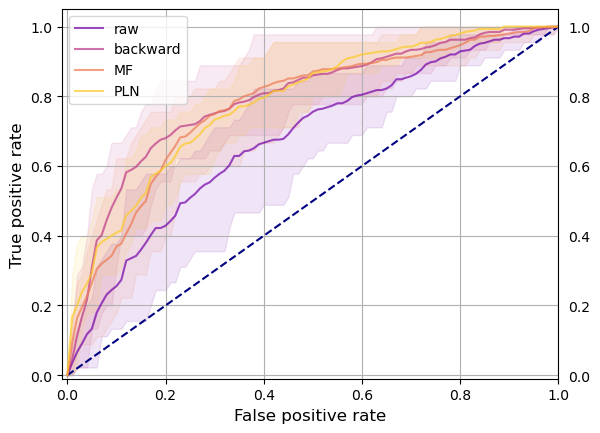

In [92]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {}
multiple_performances_summary(
    X_dic,
    y,
    LogisticRegression, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_logistic_regression'
)

### Random Forest

,raw,backward,MF,PLN
accuracy,0.813 (0.021),0.799 (0.018),0.785 (0.03),0.779 (0.016)
precision,0.818 (0.023),0.797 (0.023),0.773 (0.037),0.776 (0.026)
recall,0.813 (0.021),0.799 (0.018),0.785 (0.03),0.779 (0.016)
F1,0.788 (0.03),0.773 (0.025),0.768 (0.032),0.742 (0.021)
balanced accuracy,0.688 (0.04),0.671 (0.033),0.677 (0.037),0.63 (0.025)
AUC,0.886 (0.019),0.836 (0.032),0.813 (0.036),0.855 (0.034)


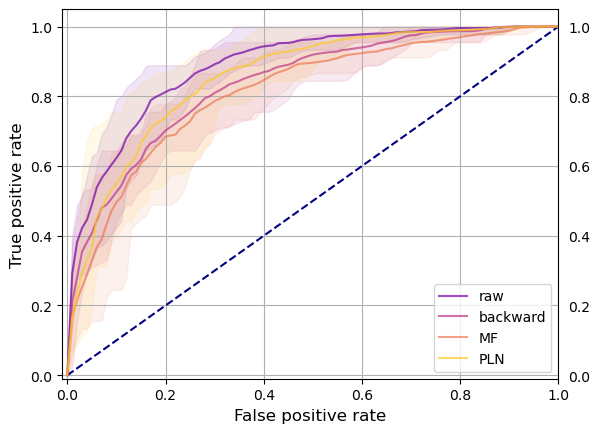

In [93]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
}
multiple_performances_summary(
    X_dic,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest'
)

,Raw $\ell=6$,PLN $\ell=2$,PLN $\ell=3$,PLN $\ell=4$,PLN $\ell=5$
accuracy,0.813 (0.021),0.755 (0.022),0.785 (0.021),0.787 (0.01),0.779 (0.016)
precision,0.818 (0.023),0.735 (0.039),0.777 (0.031),0.782 (0.016),0.776 (0.026)
recall,0.813 (0.021),0.755 (0.022),0.785 (0.021),0.787 (0.01),0.779 (0.016)
F1,0.788 (0.03),0.713 (0.025),0.755 (0.028),0.755 (0.012),0.742 (0.021)
balanced accuracy,0.688 (0.04),0.598 (0.028),0.648 (0.033),0.646 (0.015),0.63 (0.025)
AUC,0.886 (0.019),0.757 (0.035),0.815 (0.031),0.844 (0.029),0.855 (0.034)


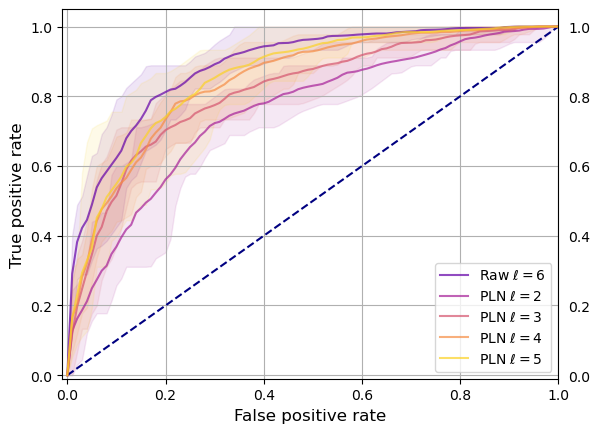

In [94]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN $\ell={i+selected_layers[0]}$'] = Z_pln_enc[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN'
)

,Raw $\ell=6$,PLN-Tree (backward) $\ell=2$,PLN-Tree (backward) $\ell=3$,PLN-Tree (backward) $\ell=4$,PLN-Tree (backward) $\ell=5$
accuracy,0.813 (0.021),0.748 (0.021),0.785 (0.02),0.789 (0.022),0.797 (0.019)
precision,0.818 (0.023),0.724 (0.035),0.776 (0.032),0.779 (0.03),0.793 (0.024)
recall,0.813 (0.021),0.748 (0.021),0.785 (0.02),0.789 (0.022),0.797 (0.019)
F1,0.788 (0.03),0.707 (0.023),0.758 (0.022),0.766 (0.027),0.771 (0.027)
balanced accuracy,0.688 (0.04),0.592 (0.025),0.653 (0.024),0.666 (0.033),0.669 (0.035)
AUC,0.886 (0.019),0.753 (0.032),0.82 (0.03),0.823 (0.03),0.836 (0.032)


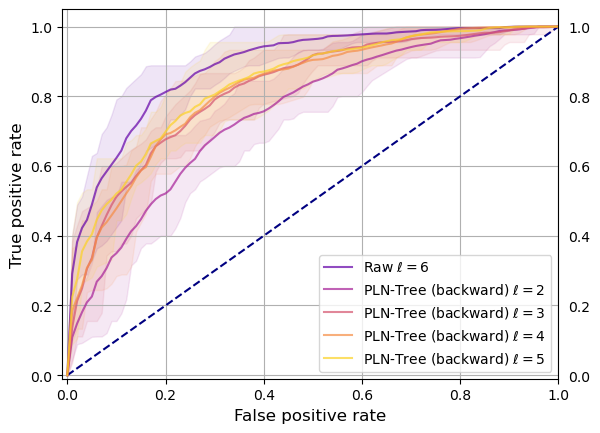

In [95]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN-Tree (backward) $\ell={i+selected_layers[0]}$'] = backward.latent_tree_allocation(Z_backward).detach()[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN-Tree_backward'
)

### SVM

,raw,backward,MF,PLN
accuracy,0.733 (0.008),0.75 (0.009),0.753 (0.019),0.756 (0.01)
precision,0.735 (0.09),0.758 (0.033),0.76 (0.055),0.767 (0.029)
recall,0.733 (0.008),0.75 (0.009),0.753 (0.019),0.756 (0.01)
F1,0.636 (0.014),0.68 (0.017),0.683 (0.029),0.691 (0.019)
balanced accuracy,0.521 (0.012),0.562 (0.017),0.564 (0.028),0.572 (0.019)
AUC,0.764 (0.052),0.835 (0.029),0.817 (0.044),0.83 (0.023)


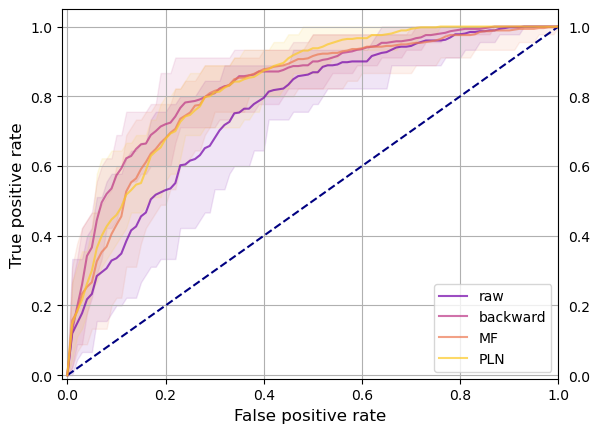

In [96]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':True
}
multiple_performances_summary(
    X_dic,
    y,
    SVC, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_SVM'
)

### Neural network

,raw,backward,MF,PLN
accuracy,0.787 (0.018),0.783 (0.016),0.787 (0.029),0.8 (0.016)
precision,0.776 (0.022),0.779 (0.016),0.781 (0.032),0.794 (0.018)
recall,0.787 (0.018),0.783 (0.016),0.787 (0.029),0.8 (0.016)
F1,0.778 (0.022),0.78 (0.015),0.779 (0.031),0.795 (0.018)
balanced accuracy,0.703 (0.033),0.716 (0.021),0.709 (0.048),0.729 (0.033)
AUC,0.798 (0.037),0.802 (0.032),0.789 (0.038),0.832 (0.022)


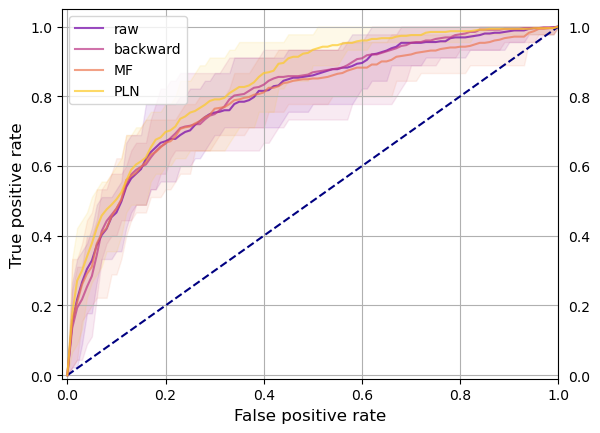

In [97]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':(64, 64, 64),
}
multiple_performances_summary(
    X_dic,
    y,
    MLPClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_MLP'
)

## PLN-Tree

In [21]:
from plntree.models import PLNTreeConditional
from plntree.data.utils import numpy_dataset_to_torch_dataloader

def bootstrap_train_plntree(X, y, 
                            n_latent_layers, variational_approx, variational_approx_params, 
                            classif_type, classif_params, 
                            n_repeats=1, train_size=0.8, n_epoch=25_000, seed=None
                           ):
    seed_all(seed)
    models = []
    losses_list = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        curr_seed = np.random.randint(1000)
        if 'backward' in variational_approx:
            varapproxTag = f"{variational_approx_params['preprocessing'][0]}-Emb{variational_approx_params['embedder_type']}-{variational_approx_params['n_embedding_layers']}x{variational_approx_params['n_embedding_neurons']}to{variational_approx_params['embedding_size']}-{variational_approx_params['n_after_layers']}"
        else:
            varapproxTag = f"{variational_approx_params['preprocessing'][0]}-varLayers{variational_approx_params['n_variational_layers']}"
        classifierTag = str(classif_type.__name__) + "-"
        if 'DenseClassifier' in classifierTag:
            classifierTag = classifierTag + f"{classif_params['hidden_sizes']}"
        else:
            classifierTag = classifierTag + f"{classif_params['hidden_size']}x{classif_params['n_layers']}"
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        dataloader = numpy_dataset_to_torch_dataloader(X_train, y_train, onehot=True, shuffle=False, batch_size=len(X_train), seed=curr_seed)
        try:
            estimator, losses = load_pkl(prefix, f's{curr_seed}_{n_latent_layers}-{varapproxTag}_{classifierTag}_fold-{i}')
        except:
            print(f'Learning PLN-Tree {i+1}/{n_repeats}')
            classifier = classif_type(seed=curr_seed, **classif_params)
            estimator = PLNTreeConditional(
                tree=taxonomy,
                n_classes=n_classes,
                classifier=classif_type(**classif_params, seed=curr_seed),
                selected_layers=selected_layers,
                diag_smoothing_factor=1e-4,
                positive_fun='softplus',
                offset_method='constant',
                identifiable=True,
                variational_approx=variational_approx,
                variational_approx_params=variational_approx_params,
                n_latent_layers=n_latent_layers,
                seed=curr_seed,
            )
            optimizer = optim.Adam(
                estimator.parameters(),
                lr=1e-3,
            )
            estimator, losses = estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)
            save_pkl((estimator, losses), prefix, f's{curr_seed}_{n_latent_layers}-{varapproxTag}_{classifierTag}_fold-{i}')
        models.append((estimator, train_indexes, test_indexes))
        losses_list.append(losses)
    return models, losses_list

In [22]:
Y_numeric = Y_base.factorize()[0]

### Mean-field classifier

In [23]:
n_latent_layers = 1
variational_approx = 'mean_field'
variational_approx_params = {
    'n_variational_layers':3,
    'preprocessing':['proportion'],
}

classifier_type = DenseClassifier
classifier_params = {
    'n_classes':n_classes,
    'input_size':K[-1],
    'hidden_sizes':[64, 64, 64],
    'selected_layer':-1,
}

In [24]:
benchmark_plntree_mf, losses = bootstrap_train_plntree(X_base, Y_numeric, 
                                                        n_latent_layers, variational_approx, variational_approx_params, 
                                                        classifier_type, classifier_params, 
                                                        n_repeats=1, train_size=0.8, seed=seed
                                                        )

Loading file ./experiments/saves/metagenomics_diseases_s0_s95_1-proportion-varLayers3_DenseClassifier-[64, 64, 64]_fold-0.pkl


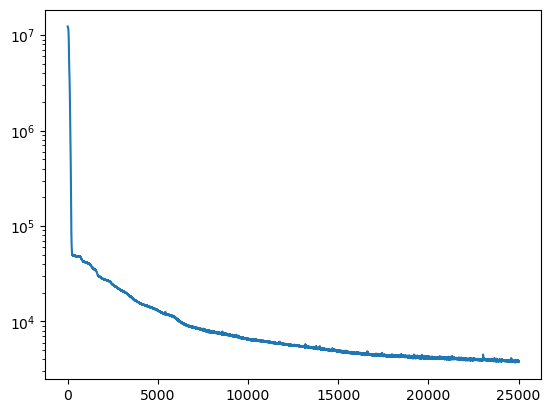

In [25]:
meanfield, train_i, test_i = benchmark_plntree_mf[0]
X_train, y_train, X_test, y_test = train_test(X_base, Y_numeric, train_i, test_i)
fig, axs = plt.subplots()
axs.plot(losses[0])
axs.set_yscale('log')

In [39]:
predict_args = {
    'n_sampling':200,
    'hmc_step':3e-5,
    'hmc_n_steps':10,
    #'sampler':'NUTS',
    'hmc_args':{'burn':50}
}

probas, Z_hmc = meanfield.predict_proba(
    X_test[:], 
    **predict_args,
    return_Z=True,
    seed=seed
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.90       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.65       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.59       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.62       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #######

Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.64       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.66       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.53       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.68       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:24 | 0d:00:00:00 | #################### | 250/250 | 10.44       
Accep

Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.62       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.56       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.63       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.49       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 250/250 | 10.69       
Accep

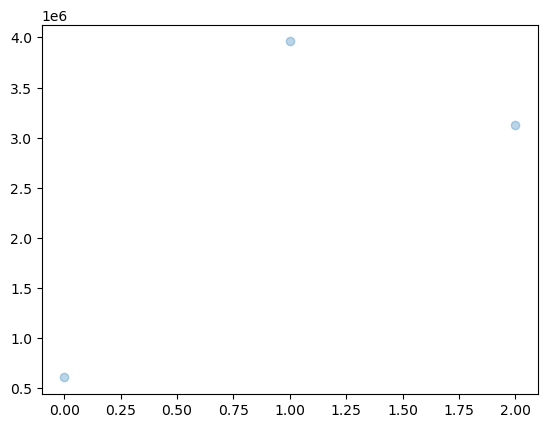

In [27]:
evals = []
for i in range(len(Z_hmc)):
    Z_i = Z_hmc[i]
    X_test_i = X_test[i]
    evals.append(meanfield.hmc_log_prob_target(Z_i[-1], X_test_i).detach())
fig, axs = plt.subplots()
axs.plot(evals, linestyle='', marker='o', alpha=0.3)

In [36]:
seed_all(seed)
predict_args = {
    'n_sampling':100,
    'hmc_step':1e-5,
    'hmc_n_steps':10,
    'sampler':'HMC',
    'hmc_args':{'burn':50}
}
performances_summary(X_base, Y_numeric, benchmark_plntree_mf, 'PLN-Tree (Conditional) - Mean Field', predict_args)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 11.41       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 11.52       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 11.22       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 150/150 | 10.68       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:16 | 0d:00:00:00 | #######

Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.85       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.80       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.87       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.84       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.89       
Accep

Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 150/150 | 10.74       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 150/150 | 10.78       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:14 | 0d:00:00:00 | #################### | 150/150 | 10.50       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.83       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 150/150 | 10.82       
Accep

ValueError: Found input variables with inconsistent numbers of samples: [163, 100]

In [ ]:
probas = meanfield.predict_proba(
    X_test, 
    n_sampling=200, 
    hmc_step=1e-5, 
    hmc_n_steps=10, 
    #hmc_args={'burn':20}, 
    seed=seed
)

In [ ]:
y_pred = probas.argmax(dim=-1)

In [ ]:
np.abs((y_test - y_pred.numpy())).sum() / len(y_test)

In [40]:
n_latent_layers = 1
variational_approx = 'residual_backward'
variational_approx_params = {
    'embedder_type': 'GRU',
    'embedding_size': 32,
    'n_embedding_layers': 2,
    'n_embedding_neurons': 64,
    'n_after_layers': 2,
    'preprocessing': ['proportion']
}

classifier_type = DenseClassifier
classifier_params = {
    'n_classes':n_classes,
    'input_size':K[-1],
    'hidden_sizes':[64, 64, 64],
    'selected_layer':-1,
}

In [43]:
benchmark_plntree_backward, losses = bootstrap_train_plntree(X_base, Y_numeric, 
                                                        n_latent_layers, variational_approx, variational_approx_params, 
                                                        classifier_type, classifier_params, 
                                                        n_repeats=10, train_size=0.8, seed=seed
                                                        )

Loading file ./experiments/saves/metagenomics_diseases_s0_s95_1-proportion-EmbGRU-2x64to32-2_DenseClassifier-[64, 64, 64]_fold-0.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_s738_1-proportion-EmbGRU-2x64to32-2_DenseClassifier-[64, 64, 64]_fold-1.pkl
Learning PLN-Tree 2/10
[*] Epoch: 100 Average loss: 4310743.4095
[*] Epoch: 200 Average loss: 76118.9491
[*] Epoch: 300 Average loss: 57290.5272
[*] Epoch: 400 Average loss: 52570.5552
[*] Epoch: 500 Average loss: 47297.2386
[*] Epoch: 600 Average loss: 41290.3142
[*] Epoch: 700 Average loss: 35389.6436
[*] Epoch: 800 Average loss: 26153.0010
[*] Epoch: 900 Average loss: 21100.7289
[*] Epoch: 1000 Average loss: 18164.3471
[*] Epoch: 1100 Average loss: 15804.5800
[*] Epoch: 1200 Average loss: 14427.8996
[*] Epoch: 1300 Average loss: 12819.3039
[*] Epoch: 1400 Average loss: 11617.3892
[*] Epoch: 1500 Average loss: 10407.0268
[*] Epoch: 1600 Average loss: 9633.1262
[*] Epoch: 1700 Average loss: 9108.5672
[*] Epoch: 1800 Averag

[*] Epoch: 19600 Average loss: 1192.9057
[*] Epoch: 19700 Average loss: 1197.8132
[*] Epoch: 19800 Average loss: 1223.8240
[*] Epoch: 19900 Average loss: 1286.2982
[*] Epoch: 20000 Average loss: 1110.0482
[*] Epoch: 20100 Average loss: 1251.4520
[*] Epoch: 20200 Average loss: 1152.9743
[*] Epoch: 20300 Average loss: 1188.6067
[*] Epoch: 20400 Average loss: 1520.1888
[*] Epoch: 20500 Average loss: 1236.6006
[*] Epoch: 20600 Average loss: 1157.2238
[*] Epoch: 20700 Average loss: 1263.3783
[*] Epoch: 20800 Average loss: 1245.3496
[*] Epoch: 20900 Average loss: 1197.4072
[*] Epoch: 21000 Average loss: 1191.5087
[*] Epoch: 21100 Average loss: 1447.4183
[*] Epoch: 21200 Average loss: 1231.3295
[*] Epoch: 21300 Average loss: 1172.7451
[*] Epoch: 21400 Average loss: 1089.0556
[*] Epoch: 21500 Average loss: 1042.3784
[*] Epoch: 21600 Average loss: 1180.6965
[*] Epoch: 21700 Average loss: 1295.0252
[*] Epoch: 21800 Average loss: 1183.1377
[*] Epoch: 21900 Average loss: 1179.6342
[*] Epoch: 22000

[*] Epoch: 14100 Average loss: 1524.7743
[*] Epoch: 14200 Average loss: 1462.1984
[*] Epoch: 14300 Average loss: 1494.8714
[*] Epoch: 14400 Average loss: 1473.7271
[*] Epoch: 14500 Average loss: 1555.4194
[*] Epoch: 14600 Average loss: 1441.8606
[*] Epoch: 14700 Average loss: 1453.4202
[*] Epoch: 14800 Average loss: 1489.2332
[*] Epoch: 14900 Average loss: 1577.6572
[*] Epoch: 15000 Average loss: 1851.4794
[*] Epoch: 15100 Average loss: 1384.9605
[*] Epoch: 15200 Average loss: 1426.9854
[*] Epoch: 15300 Average loss: 1330.3131
[*] Epoch: 15400 Average loss: 1371.9877
[*] Epoch: 15500 Average loss: 1373.3641
[*] Epoch: 15600 Average loss: 1431.7016
[*] Epoch: 15700 Average loss: 1502.1482
[*] Epoch: 15800 Average loss: 1384.3379
[*] Epoch: 15900 Average loss: 1363.4701
[*] Epoch: 16000 Average loss: 1426.4909
[*] Epoch: 16100 Average loss: 1309.1559
[*] Epoch: 16200 Average loss: 1381.2135
[*] Epoch: 16300 Average loss: 1348.2925
[*] Epoch: 16400 Average loss: 1293.4501
[*] Epoch: 16500

[*] Epoch: 8600 Average loss: 1951.4849
[*] Epoch: 8700 Average loss: 1968.1716
[*] Epoch: 8800 Average loss: 1955.6972
[*] Epoch: 8900 Average loss: 2144.5678
[*] Epoch: 9000 Average loss: 2000.6881
[*] Epoch: 9100 Average loss: 1892.6549
[*] Epoch: 9200 Average loss: 1944.9766
[*] Epoch: 9300 Average loss: 1910.6463
[*] Epoch: 9400 Average loss: 1885.4681
[*] Epoch: 9500 Average loss: 1851.9673
[*] Epoch: 9600 Average loss: 1788.2907
[*] Epoch: 9700 Average loss: 1804.8855
[*] Epoch: 9800 Average loss: 1821.9820
[*] Epoch: 9900 Average loss: 2036.6153
[*] Epoch: 10000 Average loss: 1733.7517
[*] Epoch: 10100 Average loss: 1817.1097
[*] Epoch: 10200 Average loss: 1709.6350
[*] Epoch: 10300 Average loss: 1833.1516
[*] Epoch: 10400 Average loss: 1851.6545
[*] Epoch: 10500 Average loss: 1797.8435
[*] Epoch: 10600 Average loss: 1838.6126
[*] Epoch: 10700 Average loss: 1728.3632
[*] Epoch: 10800 Average loss: 1686.2285
[*] Epoch: 10900 Average loss: 1670.5859
[*] Epoch: 11000 Average loss:

[*] Epoch: 3000 Average loss: 5324.9806
[*] Epoch: 3100 Average loss: 5101.3175
[*] Epoch: 3200 Average loss: 4975.0448
[*] Epoch: 3300 Average loss: 4687.6229
[*] Epoch: 3400 Average loss: 4850.5999
[*] Epoch: 3500 Average loss: 4539.5036
[*] Epoch: 3600 Average loss: 4472.6699
[*] Epoch: 3700 Average loss: 4466.1712
[*] Epoch: 3800 Average loss: 4101.3659
[*] Epoch: 3900 Average loss: 3819.0652
[*] Epoch: 4000 Average loss: 3817.1695
[*] Epoch: 4100 Average loss: 3794.0646
[*] Epoch: 4200 Average loss: 3795.5022
[*] Epoch: 4300 Average loss: 3761.3694
[*] Epoch: 4400 Average loss: 3642.4537
[*] Epoch: 4500 Average loss: 3455.1201
[*] Epoch: 4600 Average loss: 3408.2227
[*] Epoch: 4700 Average loss: 3435.3123
[*] Epoch: 4800 Average loss: 3446.1496
[*] Epoch: 4900 Average loss: 3339.1758
[*] Epoch: 5000 Average loss: 3166.0930
[*] Epoch: 5100 Average loss: 3102.5859
[*] Epoch: 5200 Average loss: 3068.8024
[*] Epoch: 5300 Average loss: 3019.8703
[*] Epoch: 5400 Average loss: 2937.0364


[*] Epoch: 23200 Average loss: 1112.2105
[*] Epoch: 23300 Average loss: 1081.5105
[*] Epoch: 23400 Average loss: 1035.4604
[*] Epoch: 23500 Average loss: 1126.4114
[*] Epoch: 23600 Average loss: 1080.8021
[*] Epoch: 23700 Average loss: 1180.6791
[*] Epoch: 23800 Average loss: 1103.2628
[*] Epoch: 23900 Average loss: 1006.2903
[*] Epoch: 24000 Average loss: 1060.2164
[*] Epoch: 24100 Average loss: 1092.5880
[*] Epoch: 24200 Average loss: 1048.1764
[*] Epoch: 24300 Average loss: 1148.6306
[*] Epoch: 24400 Average loss: 1029.3548
[*] Epoch: 24500 Average loss: 1129.7172
[*] Epoch: 24600 Average loss: 1027.2661
[*] Epoch: 24700 Average loss: 1104.9785
[*] Epoch: 24800 Average loss: 1107.7809
[*] Epoch: 24900 Average loss: 1087.1974
[*] Epoch: 24999 Average loss: 1004.5985
Saving in file ./experiments/saves/metagenomics_diseases_s0_s340_1-proportion-EmbGRU-2x64to32-2_DenseClassifier-[64, 64, 64]_fold-4.pkl
Loading file ./experiments/saves/metagenomics_diseases_s0_s205_1-proportion-EmbGRU-2x

[*] Epoch: 17700 Average loss: 1273.0356
[*] Epoch: 17800 Average loss: 1266.4653
[*] Epoch: 17900 Average loss: 1150.7036
[*] Epoch: 18000 Average loss: 1464.4144
[*] Epoch: 18100 Average loss: 1294.8974
[*] Epoch: 18200 Average loss: 1236.3926
[*] Epoch: 18300 Average loss: 1259.8638
[*] Epoch: 18400 Average loss: 1269.3569
[*] Epoch: 18500 Average loss: 1297.7148
[*] Epoch: 18600 Average loss: 1221.4376
[*] Epoch: 18700 Average loss: 1221.0106
[*] Epoch: 18800 Average loss: 1265.9551
[*] Epoch: 18900 Average loss: 1294.5666
[*] Epoch: 19000 Average loss: 1355.7873
[*] Epoch: 19100 Average loss: 1125.2291
[*] Epoch: 19200 Average loss: 1367.7883
[*] Epoch: 19300 Average loss: 1224.1897
[*] Epoch: 19400 Average loss: 1259.6349
[*] Epoch: 19500 Average loss: 1119.4820
[*] Epoch: 19600 Average loss: 1210.7177
[*] Epoch: 19700 Average loss: 1223.2102
[*] Epoch: 19800 Average loss: 1192.3830
[*] Epoch: 19900 Average loss: 1225.6424
[*] Epoch: 20000 Average loss: 1200.8657
[*] Epoch: 20100

[*] Epoch: 12200 Average loss: 1725.3596
[*] Epoch: 12300 Average loss: 1673.0761
[*] Epoch: 12400 Average loss: 1722.1062
[*] Epoch: 12500 Average loss: 1645.0592
[*] Epoch: 12600 Average loss: 1577.1187
[*] Epoch: 12700 Average loss: 1552.3832
[*] Epoch: 12800 Average loss: 1625.1925
[*] Epoch: 12900 Average loss: 1626.5128
[*] Epoch: 13000 Average loss: 1579.4939
[*] Epoch: 13100 Average loss: 1595.7863
[*] Epoch: 13200 Average loss: 1701.4190
[*] Epoch: 13300 Average loss: 1625.5630
[*] Epoch: 13400 Average loss: 1633.1232
[*] Epoch: 13500 Average loss: 1669.4735
[*] Epoch: 13600 Average loss: 1508.0780
[*] Epoch: 13700 Average loss: 1563.3476
[*] Epoch: 13800 Average loss: 1884.5727
[*] Epoch: 13900 Average loss: 1514.6718
[*] Epoch: 14000 Average loss: 1544.8771
[*] Epoch: 14100 Average loss: 1683.9162
[*] Epoch: 14200 Average loss: 1547.5851
[*] Epoch: 14300 Average loss: 1500.0182
[*] Epoch: 14400 Average loss: 1548.1798
[*] Epoch: 14500 Average loss: 1582.3399
[*] Epoch: 14600

[*] Epoch: 6700 Average loss: 2347.2256
[*] Epoch: 6800 Average loss: 2201.2285
[*] Epoch: 6900 Average loss: 2412.8399
[*] Epoch: 7000 Average loss: 2375.2788
[*] Epoch: 7100 Average loss: 2325.5827
[*] Epoch: 7200 Average loss: 2335.6134
[*] Epoch: 7300 Average loss: 2334.7582
[*] Epoch: 7400 Average loss: 2272.3582
[*] Epoch: 7500 Average loss: 2156.4906
[*] Epoch: 7600 Average loss: 2342.7366
[*] Epoch: 7700 Average loss: 2310.4344
[*] Epoch: 7800 Average loss: 2102.0854
[*] Epoch: 7900 Average loss: 2181.1245
[*] Epoch: 8000 Average loss: 1979.5872
[*] Epoch: 8100 Average loss: 2200.6007
[*] Epoch: 8200 Average loss: 2152.7570
[*] Epoch: 8300 Average loss: 2101.8800
[*] Epoch: 8400 Average loss: 2160.7854
[*] Epoch: 8500 Average loss: 2057.6792
[*] Epoch: 8600 Average loss: 2229.1594
[*] Epoch: 8700 Average loss: 2051.2943
[*] Epoch: 8800 Average loss: 2010.5310
[*] Epoch: 8900 Average loss: 1801.0994
[*] Epoch: 9000 Average loss: 1951.7992
[*] Epoch: 9100 Average loss: 1987.5097


[*] Epoch: 1100 Average loss: 15103.8691
[*] Epoch: 1200 Average loss: 13872.5483
[*] Epoch: 1300 Average loss: 12334.6773
[*] Epoch: 1400 Average loss: 11355.2962
[*] Epoch: 1500 Average loss: 10443.2868
[*] Epoch: 1600 Average loss: 9573.4831
[*] Epoch: 1700 Average loss: 8806.1765
[*] Epoch: 1800 Average loss: 8257.9955
[*] Epoch: 1900 Average loss: 7925.7219
[*] Epoch: 2000 Average loss: 7441.8684
[*] Epoch: 2100 Average loss: 6971.1810
[*] Epoch: 2200 Average loss: 6952.7829
[*] Epoch: 2300 Average loss: 6447.4423
[*] Epoch: 2400 Average loss: 6105.0189
[*] Epoch: 2500 Average loss: 5883.5123
[*] Epoch: 2600 Average loss: 5676.7362
[*] Epoch: 2700 Average loss: 5371.1525
[*] Epoch: 2800 Average loss: 5102.8745
[*] Epoch: 2900 Average loss: 4763.1696
[*] Epoch: 3000 Average loss: 4695.5936
[*] Epoch: 3100 Average loss: 4731.3905
[*] Epoch: 3200 Average loss: 4460.6890
[*] Epoch: 3300 Average loss: 4166.3245
[*] Epoch: 3400 Average loss: 4127.7029
[*] Epoch: 3500 Average loss: 4414.

[*] Epoch: 21300 Average loss: 1401.7392
[*] Epoch: 21400 Average loss: 1153.6757
[*] Epoch: 21500 Average loss: 1154.0133
[*] Epoch: 21600 Average loss: 1147.3494
[*] Epoch: 21700 Average loss: 1321.3578
[*] Epoch: 21800 Average loss: 1286.9017
[*] Epoch: 21900 Average loss: 1142.8832
[*] Epoch: 22000 Average loss: 1145.5776
[*] Epoch: 22100 Average loss: 1048.3170
[*] Epoch: 22200 Average loss: 1332.6946
[*] Epoch: 22300 Average loss: 1071.4078
[*] Epoch: 22400 Average loss: 1110.3589
[*] Epoch: 22500 Average loss: 1238.5662
[*] Epoch: 22600 Average loss: 1303.7042
[*] Epoch: 22700 Average loss: 1115.4653
[*] Epoch: 22800 Average loss: 1097.2697
[*] Epoch: 22900 Average loss: 1237.7553
[*] Epoch: 23000 Average loss: 1102.8633
[*] Epoch: 23100 Average loss: 1102.7277
[*] Epoch: 23200 Average loss: 1073.6998
[*] Epoch: 23300 Average loss: 995.3616
[*] Epoch: 23400 Average loss: 1136.7170
[*] Epoch: 23500 Average loss: 1051.3342
[*] Epoch: 23600 Average loss: 1157.7692
[*] Epoch: 23700 

[*] Epoch: 15800 Average loss: 1302.6527
[*] Epoch: 15900 Average loss: 1563.1690
[*] Epoch: 16000 Average loss: 1418.1517
[*] Epoch: 16100 Average loss: 1391.6955
[*] Epoch: 16200 Average loss: 1389.8791
[*] Epoch: 16300 Average loss: 1573.8520
[*] Epoch: 16400 Average loss: 1343.2031
[*] Epoch: 16500 Average loss: 1402.6049
[*] Epoch: 16600 Average loss: 1343.3653
[*] Epoch: 16700 Average loss: 1278.6908
[*] Epoch: 16800 Average loss: 1359.2944
[*] Epoch: 16900 Average loss: 1418.9138
[*] Epoch: 17000 Average loss: 1336.5822
[*] Epoch: 17100 Average loss: 1320.0032
[*] Epoch: 17200 Average loss: 1270.3816
[*] Epoch: 17300 Average loss: 1282.5932
[*] Epoch: 17400 Average loss: 1453.7953
[*] Epoch: 17500 Average loss: 1327.9847
[*] Epoch: 17600 Average loss: 1273.1260
[*] Epoch: 17700 Average loss: 1152.3080
[*] Epoch: 17800 Average loss: 1286.5657
[*] Epoch: 17900 Average loss: 1458.8670
[*] Epoch: 18000 Average loss: 1274.7658
[*] Epoch: 18100 Average loss: 1263.2354
[*] Epoch: 18200

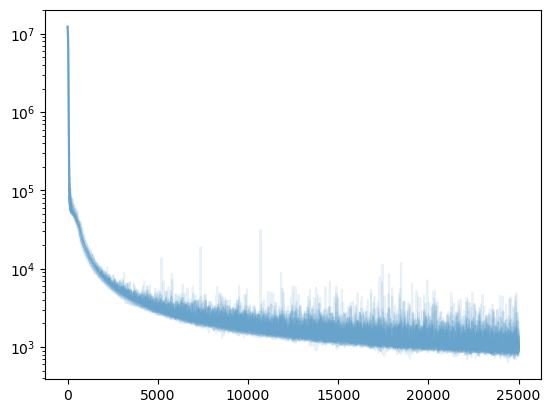

In [46]:
plntree, train_i, test_i = benchmark_plntree_backward[0]
X_train, y_train, X_test, y_test = train_test(X_base, Y_numeric, train_i, test_i)
fig, axs = plt.subplots()
for loss in losses: 
    axs.plot(loss, alpha=0.1, color='C0')
axs.set_yscale('log')